# Chapter 6 - Bayesian optimization: Automating experimental optimization

Review:
- In Chapter 2 we ta;lked about how to take a measurement of a business metric
- In Chapter 3 and 5, we balanced exploration with exploitation (Thompson sampling)
- In Chapter 4 (Response Surface Methodology), we used a surrogate function to reduce the number of measurements we had to take

Bayesian Optimization (BO) combines all of these ideas.

Removes the subjectivity found in RSM:
- Engineer doesn't have to decide which parameters to measure; that's left to the algorithm
- Steps can be automated, leading to less engineer time mucking about with it

## Optimizing  single compiler parameter - a visual explanation

![](./sweet2023-ch06-fig1.png)

We want to find the best combination of compiler parameters to minimize the compile time.

JIT compiler has 7 parameters, each between 0 and 1. They actually represent things to do with how the compiler works, but for our purposes they... just kind of exist.

Basic idea: we'll come up with a set of parameter values, then measure in a real-world situation. This will give us the speed, and from there we can make an assessmen of the quality of the combination of parameters.

We'll start by optimizing over a single parameter.

### Simulate the compiler

In [135]:
import numpy as np
import matplotlib.pyplot as plt

In [136]:
def jit_plus_server(parameters):
    x = np.array(parameters)
    d = len(x)
    x1 = x - 0.15 * np.ones(shape=(d,))
    x2 = x - 0.85 * np.ones(shape=(d,))
    first_part = np.exp(-10 * x1 ** 2)
    second_part = np.exp(-10 * x2 ** 2)
    cpu_time = 2 - first_part - 0.5 * second_part
    return cpu_time.mean() + 0.05 * np.random.normal()

### Run the initial experiment

Bayesian optimization will model the response surface from measurements of the CPU time. However, we need to start it off somewhere! Answer: just choose whatever value you want. We might as well start from the centre: measure at 0.5.

(For now we'll pretend it only has one parameter - we'll add the other ones in later)

In [137]:
np.random.seed(17)
value = jit_plus_server([ 0.5 ])
value

1.5731767440157667

### Analyze: model the response surface

First we model the response surface, then we take some measurements.

Here is a picture of the response surface. It would be nice if we got some code to go along with it, but oh well.

![](./sweet2023-ch06-fig3.png)

### Design: Select the parameter value to measure next.

We next want to measure the paramter value that would give us the most information. As you can see from the picture, there are two places where the uncertaintly is maximized - 0 and 1. We can choose either of those to measure next. Arbitrarily, we choose 0.

In [138]:
np.random.seed(17)
parameter = 0
cpu_time = jit_plus_server([parameter])
cpu_time

1.214932999472144

Basic idea:
- Define an initial parameter value to measure (say, the centre point)
- Run the experiment to find the CPU time
- Analyze the result by building the response surface from the measurement
- Design the second experiment based on that model
- Run the second experiment
- Analyze the second result by building a response surface model from the two measurements

![](./sweet2023-ch06-fig4.png)

We're going to keep doing this until the response surface stops changing.

### Design: Balance exploration with exploitation

We could continue to choose the parameter values that minimize the uncertainty - that is, improve the quality of the surrogate function. But at some point we don't really care about that - we want to decrease the CPU time. Just like with Thompson sampling, we want to balance smplaing places we know against the possibility that a dfferent parameter value might be better.

One heuristic: we want the dashed line to be low and the grey area (uncertainty) to be high. One way to do this: find the lowest point of the grey area.

![](./sweet2023-ch06-fig6.png)
![](./sweet2023-ch06-fig7.png)

From this, we should test `parameter = 0.11` next.

The function you use to design the next experiment is calle dhte **acquisition function**.

Here are the results of applying the same kind of process multiple times:

![](./sweet2023-ch06-fig8.png)

The values seem to be converging on 0.15. Once they reach there the values stop changing, so the experiment can stop.

## Model the response surface with Gaussian process regression

How did we come up with that response surface, and especially the uncertainty? Gaussian Process Regression. First we'll try to get the dashed line (the mean estimate), then the grey area (the uncertainty).

### Estimate the expected CPU time

Say we just have the first two measurements. We want a function to estimate the value at any other parameter value.

#### Take an average
One very simple way would be to simply take the average: (1.54 + 1.21) / 2 = 1.375. Let's start there.

In [139]:
class GPR1:
    def __init__(self, parameters, measurements):
        self.x = parameters
        self.y = measurements
        self.mean_y = self.y.mean()

    def estimate(self, query_parameters):
        return self.mean_y

#### Weight nearer measurements more

This is obviously not the best estimate. One way to improve it would be to weight the measurements nearer to where we're estimating more and those farther away less. We take a weighted average, where the weight is related to the distance between the point at which we're estimating and the values for which we measured a parameter value.

We need the weights to sum to 1. By convention, we use a **squared exponential kernel** - `weight = np.exp(-(x - parameter) ** 2)`.

Actually we need to change this a bit to account for the shape of the data (how large it is, &c.): `weight = np.exp(-(( x - parameter ) / (2 * sigma)) ** 2)`;

This is basically the normal distribution?

Text(0, 0.5, 'Weight')

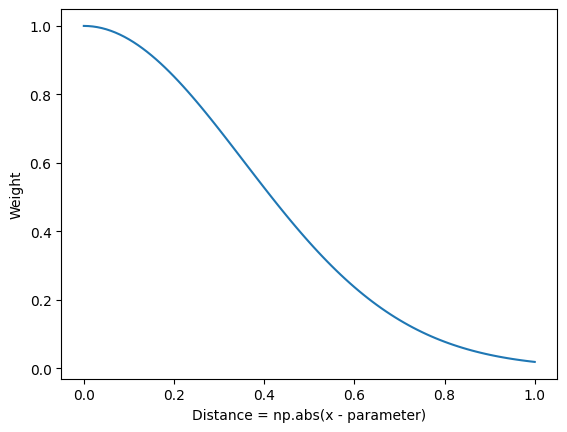

In [140]:
def squared_exponential_weight(diff):
    return np.exp(-(diff / ( 2 * 0.25 )) ** 2) # sigma = 0.25

x = np.linspace(0, 1, 101)
y = squared_exponential_weight(x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Distance = np.abs(x - parameter)")
ax.set_ylabel("Weight")

The kernel function tells us how much to weight a measurement as a function of the distance to that measurement.

The sigma parameter is a hyperparameter that has something to do with how quickly we start to discount measurements. Generally we choose the value we'll use using Leave-One-Out Cross validation, but for now we'll just take it arbitrarily.j


In [141]:
class GPR2:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        self.y -= self.mean_y # normalizing it

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2)
        return np.exp( -distance_squared / (2 * self.sigma ** 2 ))

    def estimate(self, query_parameter):
        weights = [self.kernel(x, query_parameter) for x in self.x]
        weights = np.array(weights)
        weights = weights / weights.sum() # ensure that the weights sum to 1
        return self.mean_y + weights @ self.y

In [142]:
parameters = [0.5, 0]
measurements = [1.52, 1.21]
gpr = GPR2(parameters, measurements, sigma=0.25)
print(gpr.estimate(0.25))
print(gpr.estimate(0.4))

1.365
1.4482426828846955


To create an estimate, GPR takes a weighted average of measurements and uses a kernel fnction for the weights. This is the basic idea, but there's one more thing we need to take care of.

#### Don't overweight clustered measurements

Right now, we require that measurements taken near each other have similar values; that's just the way that the model works. To avoid this, we want to downweight any clusters - they shouldn't overpower everything around them. We'll do that using the same kernel function as before, but now on the distance between estimates rather than the distance between the data and the estimate.

In [143]:
class GPR3:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        self.y -= self.mean_y # normalizing it

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2)
        return np.exp( -distance_squared / (2 * self.sigma ** 2 ))

    def estimate(self, query_parameter):
        kernels_x_query = np.array(
            [ self.kernel(x, query_parameter) for x in self.x ]
        )
        kernels_x_x = np.array([
            [ self.kernel(x1, x2) for x1 in self.x ] for x2 in self.x
        ])
        weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)
        return self.mean_y + weights @ self.y

Text(0, 0.5, 'CPU Time')

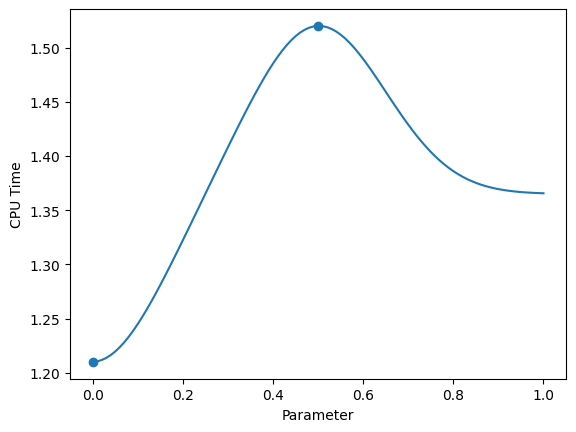

In [144]:
# Re-creating the estimate graph from before:

fig, ax = plt.subplots()
parameters = [0.5, 0]
measurements = [1.52, 1.21]
gpr3 = GPR3(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 101)
y_hats = [gpr3.estimate(x_hat) for x_hat in x_hats]

ax.plot(x_hats, y_hats) #estimate
ax.scatter(parameters, measurements) # measured values
ax.set_xlabel("Parameter")
ax.set_ylabel("CPU Time")

#### Compare to RSM

GPR differs from RSM in a few key ways:
- Linear regression requires the engineer to specify which ters to include in the model; GPR has a hyperparameter, sigma, instead.
- Linear regression has a fitting step where the beta values are determined. Once the betas are known, you may use the model to estimate the response surface. HPR estimates directly from dat without a fitting step.

### Estimate uncertainty with GPR

Now we need to estimate the model uncertainty!

Distinguish between *measurement uncertainty* - standard error - and GPR's model uncertainty. Measurement unertainty is a variation in the value of repeated mesurements (e.g. many individual measurements of the CPU time). GPR measurements are uncertain because they are made at parameters where we haven't take a measurement.

Since that's the case, we expect the unceretainty to be zero at measured points and larger far away from the measured points. This naturally suggest that we re-use our squared distance kernel to quantify the uncertainty!

Of course, this means that we can't compare uncertainties from one GPR model to another.

For technical reason, we deal with the squared certainty:

`certainty_squared = weights @ kernels_x_query`

Of course, we want the *uncertainty*:

`uncertainty_squared = 1 - certainty_squared = 1 - weights @ kernels_x_query`

Now we want to scale the uncertainty so that it's measured in the same units and on the same scale as the measurements.

In [145]:
class GPR4:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        if len(self.y) > 1:
            self.std_y = self.y.std()
        else:
            self.std_y = 1

        self.y -= self.mean_y # normalizing it

    def kernel(self, x1, x2):
        distance_squared = ((x1 - x2) ** 2)
        return np.exp( -distance_squared / (2 * self.sigma ** 2 ))

    def estimate(self, query_parameter):
        kernels_x_query = np.array(
            [ self.kernel(x, query_parameter) for x in self.x ]
        )
        kernels_x_x = np.array([
            [ self.kernel(x1, x2) for x1 in self.x ] for x2 in self.x
        ])
        weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)
        expectation = self.mean_y + weights @ self.y
        uncertainty_squared = 1 - weights @ kernels_x_query
        uncertainty = np.sqrt(uncertainty_squared)

        return expectation, self.std_y * uncertainty


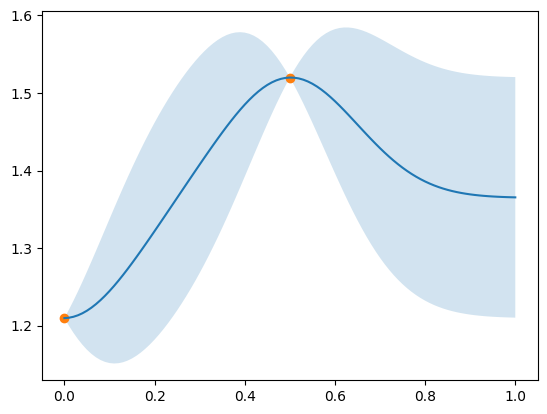

In [146]:
fig, ax = plt.subplots()
parameters = [0.5, 0]
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 101)
y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat) for x_hat in x_hats])
lower = np.array(y_hats) - np.array(sigma_y_hats)
upper = np.array(y_hats) + np.array(sigma_y_hats)

ax.fill_between(x_hats, lower, upper, alpha=0.2)
ax.plot(x_hats, y_hats)
ax.scatter(parameters, measurements)

## Optimize over an acquisition function

we want to find the place where the expectation - uncertainty is greatest - the lowest point of the pale blue section.

### Minimize the acquisition function

In Bayesian optimization, the "expectation minus uncertainty" is a specific acquisition function called the *lower confidence bound*. We can give the function more flexibility by adding in a parameter $k$: `LCB = expectation - k * uncertainty`.

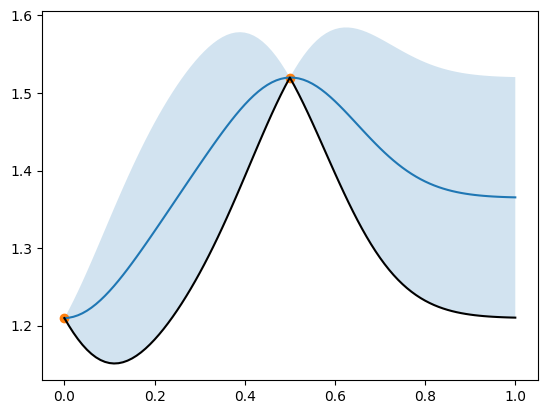

In [147]:
fig, ax = plt.subplots()
parameters = [0.5, 0]
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 101)
y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat) for x_hat in x_hats])
lower = np.array(y_hats) - np.array(sigma_y_hats)
upper = np.array(y_hats) + np.array(sigma_y_hats)

k = 1
lcb = np.array(y_hats) - k * sigma_y_hats

ax.fill_between(x_hats, lower, upper, alpha=0.2)
ax.plot(x_hats, y_hats)
ax.plot(x_hats, lcb, color="k")
ax.scatter(parameters, measurements)

By using the LCB, we trade off between the lowest current known value and our desire to explore - explore / exploit. If we use a smaller $k$, the focus more on exploiting; a larger $k$ will do more exploring.

In [148]:
i = np.where(lcb == lcb.min())
print(x_hats[i])

[0.11]


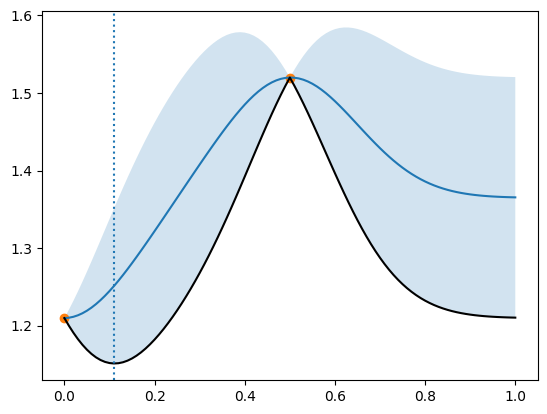

In [149]:
fig, ax = plt.subplots()
parameters = [0.5, 0]
measurements = [1.52, 1.21]
gpr4 = GPR4(parameters, measurements, sigma=0.15)
x_hats = np.linspace(0, 1, 101)
y_hats, sigma_y_hats = zip(*[gpr4.estimate(x_hat) for x_hat in x_hats])
lower = np.array(y_hats) - np.array(sigma_y_hats)
upper = np.array(y_hats) + np.array(sigma_y_hats)

k = 1
lcb = np.array(y_hats) - k * sigma_y_hats

ax.fill_between(x_hats, lower, upper, alpha=0.2)
ax.plot(x_hats, y_hats)
ax.plot(x_hats, lcb, color="k")
ax.scatter(parameters, measurements)

ax.axvline(x_hats[i], linestyle='dotted')

## Optimize all seven compiler parameters

Now we run into a problem. To find the minimum value of the acquisition function, we evaluated it at 100 different values and chose the minimum. However, with sven parameters that would result in $100^7$ different evaluations - too many!

### Random search

One simple way to do the search is called *random search*. Basically,
1. Generate a random value of the parameters - the *current parameter vector*
1. Generate a new one by adding a small random value to each of the parameter values
1. Evaluate the AF at the the new parameter value
1. If the new parameter vector has a lower LCB then that is the new vector; otherwise keep it the same

In [150]:

class GPR4Multi:
    def __init__(self, parameters, measurements, sigma):
        self.x = parameters
        self.y = np.array(measurements)
        self.sigma = sigma

        self.mean_y = self.y.mean()
        if len(self.y) > 1:
            self.std_y = self.y.std()
        else:
            self.std_y = 1

        self.y -= self.mean_y # normalizing it

    def kernel(self, x1, x2):
        # print(x1, x2)
        distance_squared = ((x1 - x2) ** 2).sum()
        return np.exp( -distance_squared / (2 * self.sigma ** 2 ))

    def estimate(self, query_parameter):
        kernels_x_query = np.array(
            [ self.kernel(x, query_parameter) for x in self.x ]
        )
        kernels_x_x = np.array([
            [ self.kernel(x1, x2) for x1 in self.x ] for x2 in self.x
        ])
        weights = kernels_x_query.T @ np.linalg.inv(kernels_x_x)
        expectation = self.mean_y + weights @ self.y
        uncertainty_squared = 1 - weights @ kernels_x_query
        uncertainty = np.sqrt(uncertainty_squared)

        return expectation, self.std_y * uncertainty


In [151]:
def evaluate(gpr, x):
    x = np.mod(x, 1)
    y, sigma_y = gpr.estimate(x)
    lcb = y - sigma_y
    return x, lcb

def random_search(gpr, num_parameters, num_iterations = 1000):
    step_size = 0.1
    x_current = np.random.normal(size=num_parameters)
    x_current, lcb_current = evaluate(gpr, x_current)
    for _ in range(num_iterations):
        x_test = x_current + step_size * np.random.normal(size=num_parameters)
        x_test, lcb_test = evaluate(gpr, x_test)
        if lcb_test < lcb_current:
            lcb_current = lcb_test
            x_current = x_test
            print(x_current)
    return x_current


In [152]:
np.random.seed(17)
parameters = [np.array([0.5]), np.array([0])]
measurements = [1.52, 1.21]
gpr4 = GPR4Multi(parameters, measurements, sigma=0.15)
random_search(gpr4, num_parameters=1)

[0.09080308]
[0.10567059]
[0.11605622]
[0.11568661]
[0.10662341]
[0.10911355]
[0.11285128]
[0.11013666]
[0.11096591]


array([0.11096591])

So we're finding the value! For one parameter it doesn't really make sense to do this - we took 1000 iterations vs. 100 by brute forcing it, for for more parameters we quickly see the savings. Also, it actually converges way faster than the 1000 iterations we took - we are accurate to within three decimal places within about 200 iterations.

### A complete Bayesian optimization

The "inner loop" of an Bayesian optimization loop is
- *Design*: Minimize the LCB over the surrogate function to find the next parameter value to measure by `random_search`
- *Run*: Measure the CPU time using `jit_plus_server`, the simulator
- *Analyze*: Build the surrogate function using `GPR4Multi`

In [153]:
class BayesianOptimizer:
    def __init__(self, num_parameters):
        self.num_parameters = num_parameters
        self.parameters = []
        self.measurements = []
        self.x0 = np.array([0.5] * num_parameters) # initially start at the midpoint of all parameters

    def ask(self):
        if len(self.measurements) == 0:
            return self.x0
        return self.new_parameter()
    
    def new_parameter(self):
        gpr = GPR4Multi(self.parameters, self.measurements, sigma=0.15)
        new_value = random_search(gpr, self.num_parameters)
        return new_value
    
    def tell(self, parameter, measurement):
        self.parameters.append(parameter)
        self.measurements.append(measurement)

In [154]:
np.random.seed(17)
bo = BayesianOptimizer(num_parameters=7)
indices = range(48)
cpu_times = []
for index in indices:
    parameter = bo.ask()
    cpu_time = jit_plus_server(parameter)
    cpu_times.append(cpu_time)
    bo.tell(parameter, cpu_time)

[0.96784369 0.75538876 0.09796648 0.92796748 0.86163619 0.79007228
 0.74102557]
[0.18149106 0.65242806 0.56436271 0.69238524 0.37211542 0.24003478
 0.8588377 ]
[0.23673074 0.69358961 0.52417627 0.59626146 0.27515176 0.25058832
 0.86212917]
[0.15146378 0.58104718 0.43988348 0.56762904 0.0826858  0.37220531
 0.68331455]
[0.15357829 0.42272096 0.42135779 0.52704073 0.11221637 0.4191017
 0.56697153]
[0.33456214 0.47582037 0.43590788 0.55337264 0.09734765 0.41102366
 0.36988411]
[0.49049075 0.63762136 0.46192644 0.46996971 0.07088098 0.49360246
 0.489031  ]
[0.31580042 0.6317996  0.5358657  0.33384697 0.2654625  0.54728233
 0.38498568]
[0.45942953 0.59174679 0.52668727 0.30914259 0.30891322 0.63997631
 0.40009301]
[0.66495679 0.48477104 0.60520201 0.32829575 0.3526808  0.52174415
 0.56264138]
[0.52902887 0.50961223 0.60955531 0.41217324 0.34161062 0.47708302
 0.40434708]
[0.61437877 0.53108707 0.4385411  0.45880992 0.45609464 0.48828835
 0.40837466]
[0.46155347 0.52968063 0.62975927 0.42742

Text(0, 0.5, 'CPU Time')

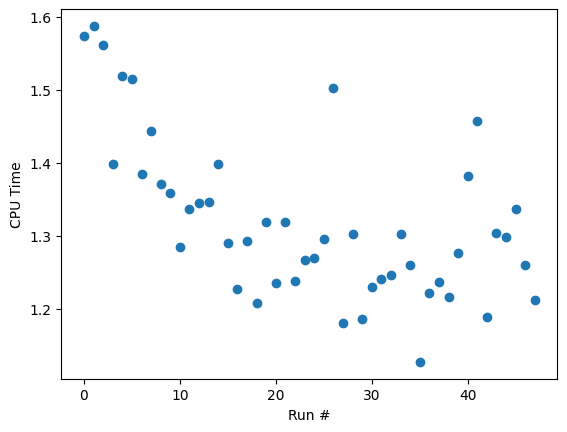

In [ ]:
fig, ax = plt.subplots()
ax.scatter(indices, cpu_times)
ax.set_xlabel('Run #')
ax.set_ylabel('CPU Time')